In [1]:
import gc
import os
import sys
import math
import random
import warnings
import pickle
from pathlib import Path
from joblib import Parallel, delayed
from statsmodels.tsa.deterministic import (CalendarFourier,
                                           CalendarSeasonality,
                                           CalendarTimeTrend,
                                           DeterministicProcess)

from tqdm import tqdm
import os
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# from pandarallel import pandarallel
# pandarallel.initialize()
warnings.simplefilter("ignore")
import ctypes as ct
from datetime import timedelta

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PowerTransformer

import lightgbm as lgbm


In [2]:
sys.path.append('../../')
import src.utils as utils

In [3]:
EXP_NUM = 1

In [4]:
DATA_DIR = Path("/home/knikaido/work/MLB-Player-Digital-Engagement-Forecasting/data/")
MAIN_DATA_DIR = DATA_DIR / 'mlb-player-digital-engagement-forecasting-update'
TRAIN_DIR = MAIN_DATA_DIR / 'train'
OUTPUT_DIR = Path('./output/')

In [5]:
players = pd.read_csv(MAIN_DATA_DIR / 'players.csv')

rosters = pd.read_csv(TRAIN_DIR / 'rosters_train.csv')
targets = pd.read_csv(TRAIN_DIR / 'nextDayPlayerEngagement_train.csv')
scores = pd.read_csv(TRAIN_DIR / 'playerBoxScores_train.csv')
scores = scores.groupby(['playerId', 'date']).sum().reset_index()
seasons = pd.read_csv(MAIN_DATA_DIR / 'seasons.csv')
twitters = pd.read_csv(TRAIN_DIR / 'playerTwitterFollowers_train.csv')
transactions = pd.read_csv(TRAIN_DIR / 'transactions_train.csv')
awards = pd.read_csv(TRAIN_DIR / 'awards_train.csv')


In [6]:
seasons = seasons.fillna('1970-01-01')
for c_ in seasons.columns[1:]:
    seasons[c_] = pd.to_datetime(seasons[c_].str.replace('-', '').astype(int), format="%Y%m%d")

In [7]:
targets = targets.merge(scores, on=['playerId', 'date'], how='left')

In [81]:
def extract_season(date_raw, season_start_end):
    idxes = 0
    for raw in season_start_end.iloc():
        idx_ = ((date_raw >= raw.iloc[0]) & (date_raw <= raw.iloc[1])) * 1
        idxes += idx_
    return idxes

In [82]:
seasons[['seasonStartDate', 'seasonEndDate']]

,seasonStartDate,seasonEndDate
0,2017-04-02,2017-11-01
1,2018-03-29,2018-10-28
2,2019-03-20,2019-10-30
3,2020-07-23,2020-10-28
4,2021-02-28,2021-10-31


In [83]:
## only on season
on_whole_idxes = extract_season(pd.to_datetime(targets['date'], format="%Y%m%d"), seasons[['seasonStartDate', 'seasonEndDate']])
targets = targets[on_whole_idxes == 1].reset_index(drop=True)

In [84]:
targets['gameday'] = ~targets['battingOrder'].isna()*1

<AxesSubplot:xlabel='gameday', ylabel='target1'>

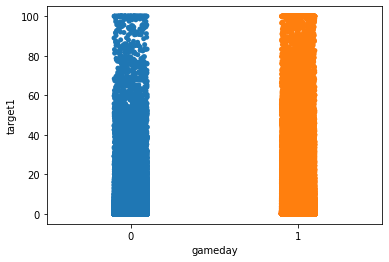

In [85]:
sns.stripplot(x="gameday", y="target1", data=targets)

(0.0, 20.0)

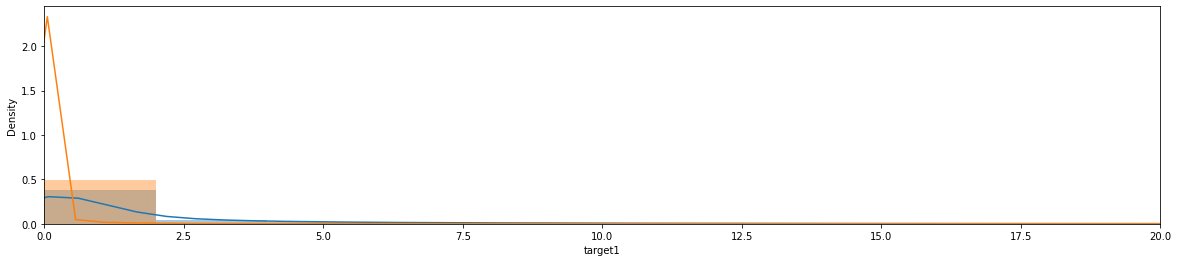

In [86]:
plt.figure(figsize=(20, 4))
sns.distplot(targets[targets['gameday']==1]['target1'])
sns.distplot(targets[targets['gameday']==0]['target1'])
plt.xlim((0, 20))

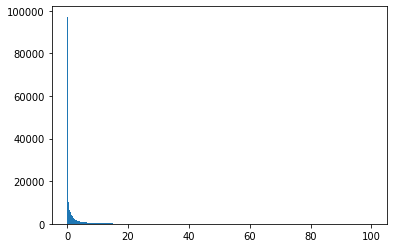

,count,mean,std,min,25%,50%,75%,max
target1,210469.0,3.295807,9.904067,0.0,0.011606,0.299571,1.996912,100.0


In [87]:
plt.hist(targets[targets['gameday'] == 1]['target1'], bins=500)
plt.show()
pd.DataFrame(targets[targets['gameday'] == 1]['target1']).describe().T

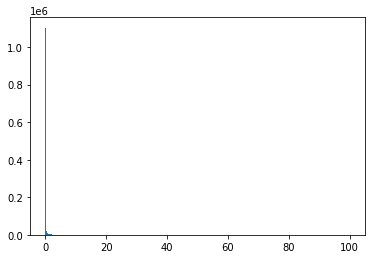

,count,mean,std,min,25%,50%,75%,max
target1,1184828.0,0.24547,2.46513,0.0,0.0,0.000353,0.00425,100.0


In [88]:
plt.hist(targets[targets['gameday'] == 0]['target1'], bins=500)
plt.show()
pd.DataFrame(targets[targets['gameday'] == 0]['target1']).describe().T

In [150]:
targets = pd.read_csv(TRAIN_DIR / 'nextDayPlayerEngagement_train.csv')

In [151]:
# on_whole_idxes = extract_season(pd.to_datetime(targets['date'], format="%Y%m%d"), seasons[['seasonStartDate', 'seasonEndDate']])
# targets = targets[on_whole_idxes == 1].reset_index(drop=True)

In [152]:
targets = targets[(targets['date']<20190601) & (targets['date']>=20190501)]

In [153]:
dates = targets['date'].unique()

In [154]:
t1_means = []
t2_means = []
t3_means = []
t4_means = []

for d_ in tqdm(dates):
    t_oneday = targets[targets['date'] == d_]
    t1_means.append(np.mean(t_oneday['target1']))
    t2_means.append(np.mean(t_oneday['target2']))
    t3_means.append(np.mean(t_oneday['target3']))
    t4_means.append(np.mean(t_oneday['target4']))

100%|██████████| 31/31 [00:00<00:00, 966.26it/s]


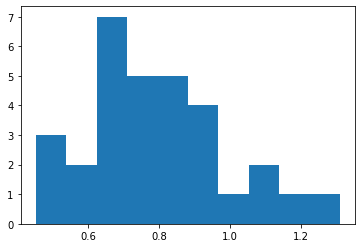

,count,mean,std,min,25%,50%,75%,max
0,31.0,0.801237,0.196984,0.452984,0.669433,0.775035,0.913763,1.309244


In [155]:
plt.hist(t1_means, bins=10)
plt.show()
pd.DataFrame(t1_means).describe().T

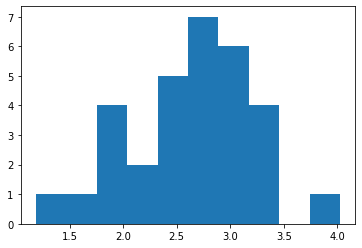

,count,mean,std,min,25%,50%,75%,max
0,31.0,2.64356,0.593734,1.184992,2.321237,2.708276,3.036913,4.026789


In [156]:
plt.hist(t2_means, bins=10)
plt.show()
pd.DataFrame(t2_means).describe().T

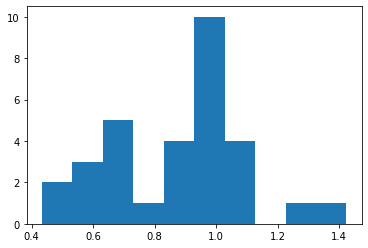

,count,mean,std,min,25%,50%,75%,max
0,31.0,0.881561,0.226045,0.434057,0.676967,0.931523,1.013447,1.4235


In [157]:
plt.hist(t3_means, bins=10)
plt.show()
pd.DataFrame(t3_means).describe().T

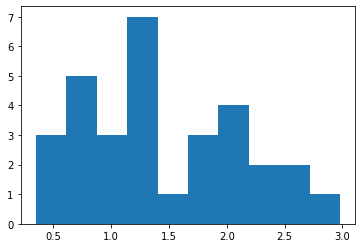

,count,mean,std,min,25%,50%,75%,max
0,31.0,1.465142,0.677644,0.347888,0.905231,1.344598,1.942522,2.981543


In [158]:
plt.hist(t4_means, bins=10)
plt.show()
pd.DataFrame(t4_means).describe().T

In [229]:
targets = pd.read_csv(TRAIN_DIR / 'nextDayPlayerEngagement_train.csv')
targets = pd.merge(targets, players, how='left', on='playerId')

In [230]:
player_ids = targets[targets['playerForTestSetAndFuturePreds']!=False]['playerId'].unique()

id=543507, name=Trevor May


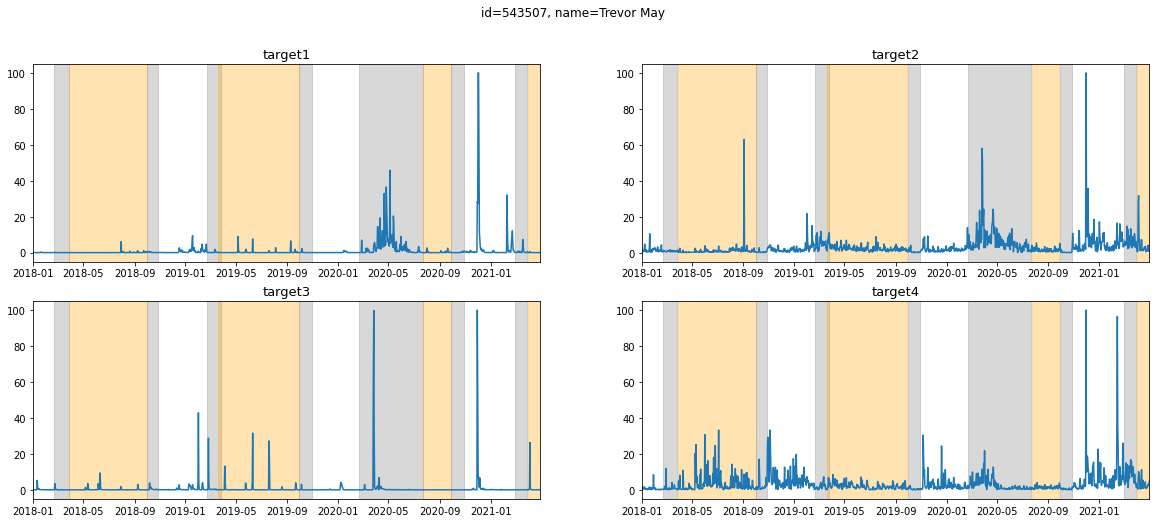

In [232]:

id_ = player_ids[np.random.randint(len(player_ids))]
# id_ = player_ids[10]
# id_ = 666201
target_oneplayer = targets[(targets['playerId'] == id_)]
name = players[players['playerId'] == id_]['playerName']
print(f'id={id_}, name={name.values[0]}')

fig, ax = plt.subplots(2, 2, figsize=(20, 8))
fig.suptitle(f'id={id_}, name={name.values[0]}')
for i in range(len(seasons)):
    ax[0][0].axvspan(seasons['preSeasonStartDate'][i], seasons['preSeasonEndDate'][i], color="gray", alpha=0.3)
for i in range(len(seasons)):
    ax[0][0].axvspan(seasons['regularSeasonStartDate'][i], seasons['regularSeasonEndDate'][i], color="orange", alpha=0.3)
for i in range(len(seasons)):
    ax[0][0].axvspan(seasons['postSeasonStartDate'][i], seasons['postSeasonEndDate'][i], color="gray", alpha=0.3)
dates = pd.to_datetime(target_oneplayer['date'], format="%Y%m%d").values
ax[0][0].plot(dates, target_oneplayer['target1'].values)
ax[0][0].set_xlim(np.min(dates), np.max(dates))
ax[0][0].set_title('target1', fontsize=13)
ax[0][0].set_aspect(aspect='auto')

for i in range(len(seasons)):
    ax[0][1].axvspan(seasons['preSeasonStartDate'][i], seasons['preSeasonEndDate'][i], color="gray", alpha=0.3)
for i in range(len(seasons)):
    ax[0][1].axvspan(seasons['regularSeasonStartDate'][i], seasons['regularSeasonEndDate'][i], color="orange", alpha=0.3)
for i in range(len(seasons)):
    ax[0][1].axvspan(seasons['postSeasonStartDate'][i], seasons['postSeasonEndDate'][i], color="gray", alpha=0.3)
dates = pd.to_datetime(target_oneplayer['date'], format="%Y%m%d").values
ax[0][1].plot(dates, target_oneplayer['target2'].values)
ax[0][1].set_xlim(np.min(dates), np.max(dates))
ax[0][1].set_title('target2', fontsize=13)
ax[0][1].set_aspect(aspect='auto')

for i in range(len(seasons)):
    ax[1][0].axvspan(seasons['preSeasonStartDate'][i], seasons['preSeasonEndDate'][i], color="gray", alpha=0.3)
for i in range(len(seasons)):
    ax[1][0].axvspan(seasons['regularSeasonStartDate'][i], seasons['regularSeasonEndDate'][i], color="orange", alpha=0.3)
for i in range(len(seasons)):
    ax[1][0].axvspan(seasons['postSeasonStartDate'][i], seasons['postSeasonEndDate'][i], color="gray", alpha=0.3)
dates = pd.to_datetime(target_oneplayer['date'], format="%Y%m%d").values
ax[1][0].plot(dates, target_oneplayer['target3'].values)
ax[1][0].set_xlim(np.min(dates), np.max(dates))
ax[1][0].set_title('target3', fontsize=13)
ax[1][0].set_aspect(aspect='auto')

for i in range(len(seasons)):
    ax[1][1].axvspan(seasons['preSeasonStartDate'][i], seasons['preSeasonEndDate'][i], color="gray", alpha=0.3)
for i in range(len(seasons)):
    ax[1][1].axvspan(seasons['regularSeasonStartDate'][i], seasons['regularSeasonEndDate'][i], color="orange", alpha=0.3)
for i in range(len(seasons)):
    ax[1][1].axvspan(seasons['postSeasonStartDate'][i], seasons['postSeasonEndDate'][i], color="gray", alpha=0.3)
dates = pd.to_datetime(target_oneplayer['date'], format="%Y%m%d").values
ax[1][1].plot(dates, target_oneplayer['target4'].values)
ax[1][1].set_xlim(np.min(dates), np.max(dates))
ax[1][1].set_title('target4', fontsize=13)
ax[1][1].set_aspect(aspect='auto')

# plt.show()

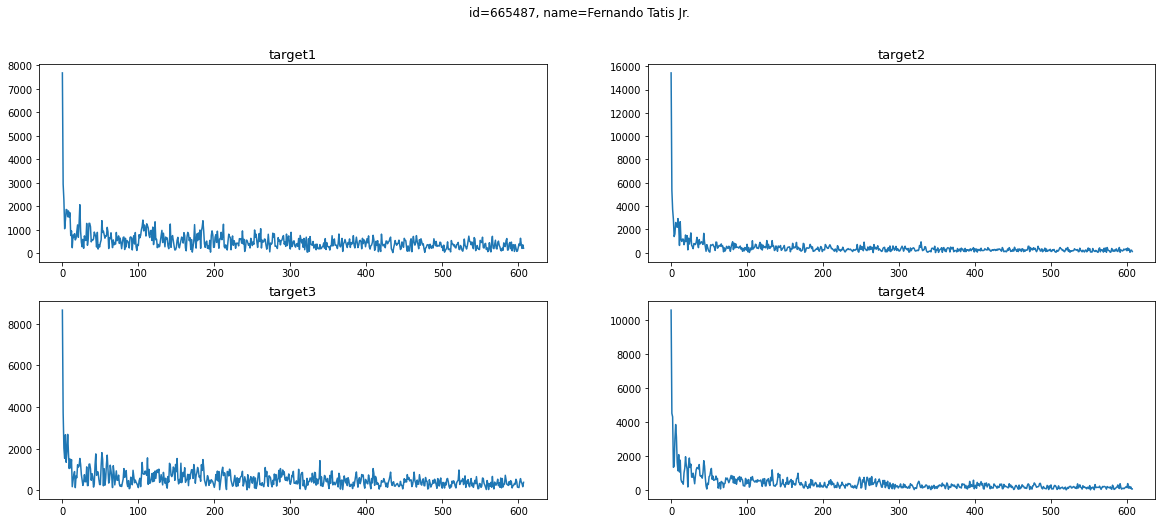

In [172]:
fig, ax = plt.subplots(2, 2, figsize=(20, 8))
fig.suptitle(f'id={id_}, name={name.values[0]}')
fft_ = np.fft.fft(target_oneplayer['target1'].values)
fft_abs = np.abs(fft_)
ax[0][0].plot(fft_abs[:int(len(fft_abs)/2)])
ax[0][0].set_title('target1', fontsize=13)
ax[0][0].set_aspect(aspect='auto')

fft_ = np.fft.fft(target_oneplayer['target2'].values)
fft_abs = np.abs(fft_)
ax[0][1].plot(fft_abs[:int(len(fft_abs)/2)])
ax[0][1].set_title('target2', fontsize=13)
ax[0][1].set_aspect(aspect='auto')

fft_ = np.fft.fft(target_oneplayer['target3'].values)
fft_abs = np.abs(fft_)
ax[1][0].plot(fft_abs[:int(len(fft_abs)/2)])
ax[1][0].set_title('target3', fontsize=13)
ax[1][0].set_aspect(aspect='auto')

fft_ = np.fft.fft(target_oneplayer['target4'].values)
fft_abs = np.abs(fft_)
ax[1][1].plot(fft_abs[:int(len(fft_abs)/2)])
ax[1][1].set_title('target4', fontsize=13)
ax[1][1].set_aspect(aspect='auto')

## target1, 3は0の区間が多い気がする

In [8]:
targets = pd.read_csv(TRAIN_DIR / 'nextDayPlayerEngagement_train.csv')

In [9]:
date_ids = targets['date'].unique()

In [10]:
max_score = []
for id_ in tqdm(date_ids):
    targets_onedate = targets[targets['date'] == id_]
    max_score.append([np.max(targets_onedate['target1']), np.max(targets_onedate['target2']), np.max(targets_onedate['target3']), np.max(targets_onedate['target4'])])

100%|██████████| 1294/1294 [00:02<00:00, 450.06it/s]


In [11]:
max_df = pd.DataFrame(max_score, columns=['target1', 'target2', 'target3', 'target4'])
max_df['target1'].unique(), max_df['target2'].unique(), max_df['target3'].unique(), max_df['target4'].unique()

(array([100.]),
 array([100.]),
 array([100.        ,  99.26011634,  99.16863879]),
 array([100.]))

In [202]:
player_ids = targets['playerId'].unique()

In [254]:
scales = []
for id_ in tqdm(date_ids):
    t1_nonzero = targets[(targets['date'] == id_) & (targets['target1'] > 0)]['target1']
    if len(t1_nonzero) == 0:
        t1 = 0
    else:
        t1 = 1 / t1_nonzero.sort_values().values[0]
        
    t2_nonzero = targets[(targets['date'] == id_) & (targets['target2'] > 0)]['target2']
    if len(t2_nonzero) == 0:
        t2 = 0
    else:
        t2 = 1 / t2_nonzero.sort_values().values[0]
        
    t3_nonzero = targets[(targets['date'] == id_) & (targets['target3'] > 0)]['target3']
    if len(t3_nonzero) == 0:
        t3 = 0
    else:
        t3 = 1 / t3_nonzero.sort_values().values[0]

    t4_nonzero = targets[(targets['date'] == id_) & (targets['target4'] > 0)]['target4']
    if len(t4_nonzero) == 0:
        t4 = 0
    else:
        t4 = 1 / t4_nonzero.sort_values().values[0]

    scales.append([id_, t1, t2, t3, t4])

100%|██████████| 1216/1216 [00:18<00:00, 66.06it/s]


In [255]:
scales_df = pd.DataFrame(scales, columns=['date', 'target1_scale', 'target2_scale', 'target3_scale', 'target4_scale'])

In [256]:
scales_df.to_csv(MAIN_DATA_DIR / 'scales.csv', index=False)

In [220]:
targets = pd.read_csv(TRAIN_DIR / 'nextDayPlayerEngagement_train.csv')

In [221]:
targets = pd.merge(targets, scales_df, how='left', on='playerId')

In [222]:
s_ = targets[['target1_scale', 'target2_scale', 'target3_scale', 'target4_scale']].values
t_ = targets[['target1', 'target2', 'target3', 'target4']].values

In [ ]:
targets = pd.merge(targets, scores, how='left', on=['playerId', 'date']) 
date_ = pd.to_datetime(targets['date'], format="%Y%m%d")
targets['month'] = date_.dt.month

In [ ]:
targets['gameday'] = targets['battingOrder'].isna()*1

In [ ]:
targets[targets['gameday']==0]

In [ ]:
plt.figure(figsize=(15, 8))
sns.violinplot(x="month", y="target1", data=targets)

In [ ]:
sns.violinplot(x="gameday", y="target2", data=targets)

In [ ]:
sns.violinplot(x="gameday", y="target3", data=targets)

In [ ]:
sns.violinplot(x="gameday", y="target4", data=targets)

In [ ]:
plt.hist(targets['target1'], bins=500)
plt.show()
pd.DataFrame(targets['target1']).describe().T

In [ ]:
plt.figure(figsize=(15, 4))
plt.plot(pd.to_datetime(targets['date'], format="%Y%m%d").values[::100], targets['target2'].values[::100])

In [ ]:
# targets.sort_values('target1', ascending=False)

In [ ]:
plt.hist(targets['target2'], bins=500)
plt.show()
pd.DataFrame(targets['target2']).describe().T

In [ ]:
plt.figure(figsize=(15, 4))
plt.plot(pd.to_datetime(targets['date'], format="%Y%m%d").values[::100], targets['target3'].values[::100])

In [ ]:
plt.hist(targets['target3'], bins=500)
plt.show()
pd.DataFrame(targets['target3']).describe().T

In [2]:
plt.figure(figsize=(15, 4))
plt.plot(pd.to_datetime(targets['date'], format="%Y%m%d").values[::100], targets['target4'].values[::100])

NameError: name 'plt' is not defined

In [ ]:
plt.hist(targets['target4'], bins=500)
plt.show()
pd.DataFrame(targets['target4']).describe().T

In [ ]:
# pt = PowerTransformer()

In [ ]:
# target4_norm = pt.fit_transform(targets['target4'].values.reshape(-1,1)).reshape(-1)

In [ ]:
# plt.hist(target4_norm, bins=500)
# plt.show()
# pd.DataFrame(target4_norm).describe().T